## This notebook generates synthetic gaia absolute astrometry, calibrated so that uncertainties match those given in the catalog.

It intakes:
1. a simbad resolvable name for a star
2. The GOST (Gaia Observation Forecast Tool) data (saved as a csv).

And outputs: A csv file with a variety of columns: the date in julian year, the ra and dec of the observation (in degrees), and the elements of the ra, dec inverse covariance matrix. 


In [1]:
simbad_name = 'HIP 3850'
gost_file_name = '003850' # just enough of the file name to match it.
gost_data_directory = 'htof/test/data_for_tests/GaiaeDR3/IntermediateData'

## End of user-set parameters.

In [2]:
from htof.main import Astrometry
import numpy as np
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import Angle
from astropy import units as u
Simbad.add_votable_fields('pmra', 'pmdec')

gaia_epoch_ra, gaia_epoch_dec = 2016, 2016
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"  # Select early Data Release 3

def get_gaiaedr3_archive_table(source_name):
    # get coordinates of object from SIMBAD
    result_table = Simbad.query_object(source_name)
    ra, dec = result_table['RA'][0], result_table['DEC'][0]
    if 'PMRA' in result_table.colnames and 'PMDEC' in result_table.colnames:
        pmra, pmdec = result_table['PMRA'][0]*u.mas/u.yr, result_table['PMDEC'][0]*u.mas/u.yr
    else:
        pmra, pmdec = 0, 0
    coordinate = SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.deg),
                          frame='icrs', equinox='j2000',
                          pm_ra_cosdec=pmra, pm_dec=pmdec,
                          obstime=Time(2000.0, format='decimalyear'))
    
    transformed_coordinate = coordinate.apply_space_motion(new_obstime=Time(gaia_epoch_ra, format='decimalyear'))
    # use those coordinates to query gaia.
        # use those coordinates to query gaia.
    results = Gaia.query_object(coordinate=transformed_coordinate, radius=5.0 * u.arcsec)
    if len(results) == 0:
        # this might be a high proper motion source, or we got the wrong proper motion from simbad.
        # try with a larger search radius around the original coordinate.
        results = Gaia.query_object(coordinate=coordinate, radius=100.0 * u.arcsec)

    if len(results) > 1:
        results = results[0]
    return Table(results)



def calibrated_gaiaedr3_astrometry(gost_file_name, parallax_error_mas, central_ra, central_dec, fit_degree=2):
    # generate an astrometry object where the along_scan_errors have been scaled to perfectly
    # match the fitted parallax error (in a five-parameter fit).
    astrometry =  Astrometry('GaiaeDR3', gost_file_name, gost_data_directory, 
                             central_epoch_ra=gaia_epoch_ra, central_epoch_dec=gaia_epoch_dec, format='jyear', 
                             central_ra=central_ra, central_dec=central_dec,
                             fit_degree=1, use_parallax=True)
    cov_matrix = astrometry.fitter.evaluate_cov_matrix(gaia_epoch_ra, gaia_epoch_dec)
    parallax_error_observed = np.sqrt(cov_matrix[0, 0])
    along_scan_error_estimate = parallax_error_mas/parallax_error_observed
    
    
    astrometry =  Astrometry('GaiaeDR3', gost_file_name, gost_data_directory, 
                             central_epoch_ra=gaia_epoch_ra, central_epoch_dec=gaia_epoch_dec, format='jyear',
                             central_ra=central_ra, central_dec=central_dec,
                             fit_degree=fit_degree, use_parallax=True, along_scan_error_scaling=along_scan_error_estimate)
    # save a few instance attributes for checking this calibration later.
    astrometry.gost_file_name = gost_file_name
    astrometry.central_ra = central_ra
    astrometry.central_dec = central_dec
    #
    return astrometry

def check_validity_of_calibrated_astrometry(gaia_catalog_t, astro: Astrometry):
    # debug check that the along scan error scaling did indeed reproduce the EDR3 parallax error.
    test_astrometry =  Astrometry('GaiaeDR3', astro.gost_file_name, gost_data_directory, 
                         central_epoch_ra=gaia_epoch_ra, central_epoch_dec=gaia_epoch_dec, format='jyear',
                         central_ra=astro.central_ra, central_dec=astro.central_dec,
                         fit_degree=1, use_parallax=True, along_scan_error_scaling=astro.along_scan_error_scaling)
    cov_matrix = test_astrometry.fitter.evaluate_cov_matrix(gaia_epoch_ra, gaia_epoch_dec)
    test_quantities = {'calculated': {'plx_err': np.sqrt(cov_matrix[0, 0]), 'pmra_err': np.sqrt(cov_matrix[-2, -2]),
                                      'pmdec_err': np.sqrt(cov_matrix[-1, -1])},
                      'catalog': {'plx_err': t['parallax_error'][0], 'pmra_err': t['pmra_error'][0],
                                  'pmdec_err': t['pmdec_error'][0]},
                      }
    assert np.isclose(np.sqrt(cov_matrix[0, 0]), t['parallax_error'][0], atol=0.00001) # By construction, this HAS to be true.
    return test_quantities

t = get_gaiaedr3_archive_table(simbad_name)
# get the necessary quantities from the table for the calibration
parallax = t['parallax'][0] * t['parallax'].unit
parallax_error = t['parallax_error'][0] * t['parallax_error'].unit
central_ra = Angle(t['ra'][0] * t['ra'].unit)
central_dec = Angle(t['dec'][0] * t['ra'].unit)
pmra, pmdec = t['pmra'][0] * t['pmra'].unit, t['pmdec'][0] * t['pmdec'].unit

astrometry = calibrated_gaiaedr3_astrometry(str(gost_file_name), parallax_error.to(u.mas).value, 
                                            central_ra, central_dec)
print(astrometry.along_scan_error_scaling, ' mas is the htof estimated along-scan error by fitting to match the parallax error.')

/home/gmbrandt/envs/htof/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


0.07375702093868661  mas is the htof estimated along-scan error by fitting to match the parallax error.


## Testing the validity of the calibration by comparing what our "calibrated" htof astrometry object says the pmra and pmdec errors are, compared to what the gaia edr3 archive says they are.

In [3]:
validity_check_results = check_validity_of_calibrated_astrometry(t, astrometry)
print(validity_check_results)

{'calculated': {'plx_err': 0.028182508426465958, 'pmra_err': 0.03295875398637716, 'pmdec_err': 0.03207566068043224}, 'catalog': {'plx_err': 0.028182508, 'pmra_err': 0.032545958, 'pmdec_err': 0.032021094}}


## The errors match almost exactly. So the GOST scans + the assumption of uniform along-scan errors is probably pretty good. Since these match, our synthetic absolute astrometric observations should be pretty good (except that they have zero scatter about the observations.. i.e. the observations are all exactly along the best-fit skypath.)

In [4]:
year_epochs = Time(astrometry.data.julian_day_epoch(), format='jd', scale='tcb').jyear - \
              Time(gaia_epoch_ra, format='decimalyear').jyear
ra_plx_factor = astrometry.fitter.parallactic_pertubations['ra_plx']
dec_plx_factor = astrometry.fitter.parallactic_pertubations['dec_plx']
ra = Angle(ra_plx_factor * parallax.to(u.mas).value + pmra.to(u.mas/u.yr).value  * year_epochs, unit='mas')
dec = Angle(dec_plx_factor * parallax.to(u.mas).value  + pmdec.to(u.mas/u.yr).value  * year_epochs, unit='mas')
ra += central_ra
dec += central_dec
# convert to degrees
ra = ra.to(u.deg)
dec = dec.to(u.deg)

## generate a comparison skypath for plotting.

In [5]:
from htof.sky_path import parallactic_motion, earth_sun_l2_ephemeris

gaia_epochs = Time(astrometry.data.julian_day_epoch(), format='jd', scale='tcb')
jyear_epochs_fine = np.linspace(np.min(gaia_epochs.jyear), np.max(gaia_epochs.jyear), 10000)
year_epochs_fine = jyear_epochs_fine - Time(gaia_epoch_ra, format='decimalyear').jyear
ra_comparison = 0
dec_comparison = 0

plx_factor_ra_fine, plx_factor_dec_fine = parallactic_motion(jyear_epochs_fine, central_ra.mas, central_dec.mas, 
                                                             'mas', gaia_epoch_ra, ephemeris=earth_sun_l2_ephemeris)

ra_comparison = Angle(plx_factor_ra_fine * parallax.to(u.mas).value + pmra.to(u.mas/u.yr).value  * year_epochs_fine, unit='mas')
dec_comparison = Angle(plx_factor_dec_fine * parallax.to(u.mas).value  + pmdec.to(u.mas/u.yr).value  * year_epochs_fine, unit='mas')
ra_comparison += central_ra
dec_comparison += central_dec
# convert to degrees
ra_comparison = ra_comparison.to(u.deg)
dec_comparison = dec_comparison.to(u.deg)

## inspect the skypath.

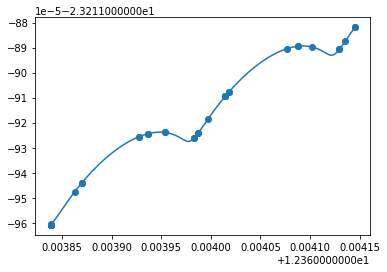

In [6]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(ra, dec)
plt.plot(ra_comparison, dec_comparison)
plt.show()

## That looks as it should.
## So lets make an astropy table and write it to disc.

In [7]:
icov = astrometry.data.inverse_covariance_matrix
t = {'#date(jyear)': gaia_epochs.jyear, 'ra(deg)': ra.deg, 'dec(deg)': dec.deg, 
     'icovrara': icov[:, 0, 0], 'icovradec': icov[:, 0, 1], 'icovdecdec': icov[:, 1, 1]}
t = Table(t, units=(u.yr, u.deg, u.deg, 1/u.mas**2, 1/u.mas**2, 1/u.mas**2))

In [8]:
t.write(simbad_name.replace(' ', '_') + 'synthetic_gaia_abs_ast.ecsv')